In [1]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import root
from scipy.interpolate import barycentric_interpolate
from scipy.interpolate import BarycentricInterpolator
from matplotlib import pyplot as plt

# Problem 1

Assume that the current is given by $c(x) = − \frac7{10} (x^2 − 1)$. This function assumes,
for example, that the current is faster near the center of the river. Write 2 python functions.
The first should accept as arguments a function $y$, its derivative $y^\prime$, and an $x$-value, and return
$L(x, y(x), y′(x))$ (where $T [y] = \int_{-1}^1 L(x, y(x), y′(x))$). The second should use the first function
to compute and return $T [y]$ for a given path $y(x)$.

In [2]:
def Lagrangian(x, y, Dy, c):
    """
    Computes the Lagrangian for the river crossing problem
    
    Parameters
    ----------
    y : callable function 
    Dy : derivative of y, callable function
    c : callable function, the river velocity
    x : a point / points at which to evaluate the Lagrangian.
    
    Returns
    -------
    L : The Lagrangian
    """
    
    alpha = lambda x: (1 - c(x)**2)**(-1/2.)
    L = alpha(x) * np.sqrt(1 + (alpha(x) * Dy(x))**2) - (alpha(x)**2 * c(x)*Dy(x))

    return L

def functional_eval(y, Dy, c, a, b):
    """
    Computes the time functional T[y]
    
    Parameters
    ----------
    y : callable function
    Dy : derivate of y, callable function
    c : callabel function, the river velocity
    a : lower integration point
    b : upper integration point
    
    Returns
    -------
    Functional evaluation using gaussian quadrature
    """
    
    return quad(Lagrangian, a, b, args=(y, Dy, c))

# Problem 2

Let $y(x)$ be the straight-line path between $A = (−1, 0)$ and $B = (1, 5)$. Numerically calculate $T [y]$ to get an upper bound on the minimum time required to cross from $A$ to
$B$. Using (7.2), find a lower bound on the minimum time required to cross.

In [3]:
def problem2():

    # current function
    c = lambda x : -7*(x**2 - 1)/10
    a, b = -1, 1
    
    # calculate upper bound by using a straight line function
    y = lambda x: 5*(x + 1)/2
    Dy = lambda x: 5/2*(x**0)
    upper_bound, upper_err = functional_eval(y, Dy, c, a, b)
    
    # the minimum of the secant function on [-1, 1] is 1
    # and the minimizer is 0. Therefore the lower_bound is 2 
    lower_bound = 2
        
    return upper_bound, lower_bound
    
upper_bound, lower_bound = problem2()

print('upper bound:', upper_bound)
print('lower bound:', lower_bound)

upper bound: 3.8770820491384126
lower bound: 2


## Problem 3

Numerically solve the Euler-Lagrange equation (7.4), using $c(x) = \frac{-7}{10} (x^2 − 1)$
and  $\alpha = (1 − c^2)^{−1/2}$, and $y(−1) = 0$, $y(1) = 5$.

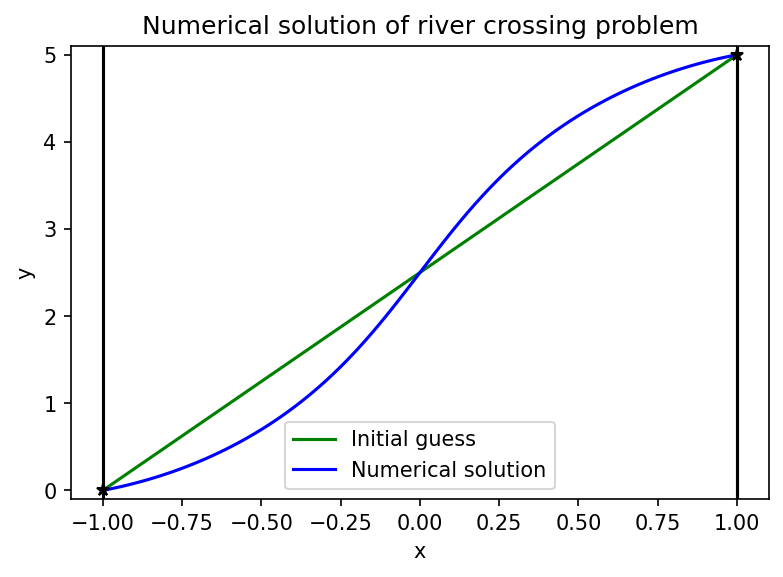

In [4]:
# calculate chebyshev points and differentiation matrix
def cheb(N):
    x = np.cos((np.pi/N)*np.linspace(0,N,N+1))
    x.shape = (N+1,1)
    lin = np.linspace(0,N,N+1)
    lin.shape = (N+1,1)
    
    c = np.ones((N+1,1))
    c[0], c[-1] = 2., 2.
    c = c*(-1.)**lin
    X = x*np.ones(N+1) # broadcast along 2nd dimension (columns)
    
    dX = X - X.T
    
    D = (c*(1./c).T)/(dX + np.eye(N+1))
    D = D - np.diag(np.sum(D.T,axis=0))
    x.shape = (N+1,)
    # Here we return the differentiation matrix and the Chebyshev points,
    # numbered from x_0 = 1 to x_N = -1
    return D, x

# calculate solution using scipy's Newton's method
def BVP_sol(N, c, α, A, B):
    #get differential matrix and x
    D, x = cheb(N)
    #square the differential matrix

    # initial guess
    guess = 5*(x+1)/2

    # calculate constants
    α1 = α(x)
    α2c = (α1**2)*c(x)
    α3 = α1**3
    
    # define function to find root of
    def F(u):
        #our result use array broad-casting
        result =  D@(α3*(D@u)*(1 + (α1*(D@u))**2)**(-1/2) - α2c)
        #set our boundary conditions
        result[0] = u[0]-B
        result[-1] = u[-1]-A
        #return the result
        return result 
    
    #use newton's method to for root finding
    solution = root(F, guess).x
    return x, solution, guess, D

def problem_3(N=50):
    
    # set functions and constants
    c = lambda x: -7*(x**2 - 1) / 10
    α = lambda x: (1 - c(x)**2)**(-1/2)
    a, b = -1, 1
    A, B = 0, 5
    
    # get solution and initial guess
    x, y, guess, _ = BVP_sol(N, c, α, A, B)
    grid = np.linspace(np.min(x), np.max(x), 100)
    y = barycentric_interpolate(x, y, grid)
    
    # plot
    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(111)
    ax.plot(x, guess, 'g-', label='Initial guess')
    ax.plot(grid, y, 'b-', label='Numerical solution')
    ax.plot(a, A, 'k*')
    ax.plot(b, B, 'k*')
    ax.axvline(-1, ymin=0, ymax=5, color='k')
    ax.axvline(1, ymin=0, ymax=5, color='k')
    ax.legend(loc='best')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-0.1, 5.1])
    ax.set_title('Numerical solution of river crossing problem')
    plt.show()

    return
    
problem_3()

# Problem 4

plot the angle at which the boat should be pointed at each $x$-coordinate.

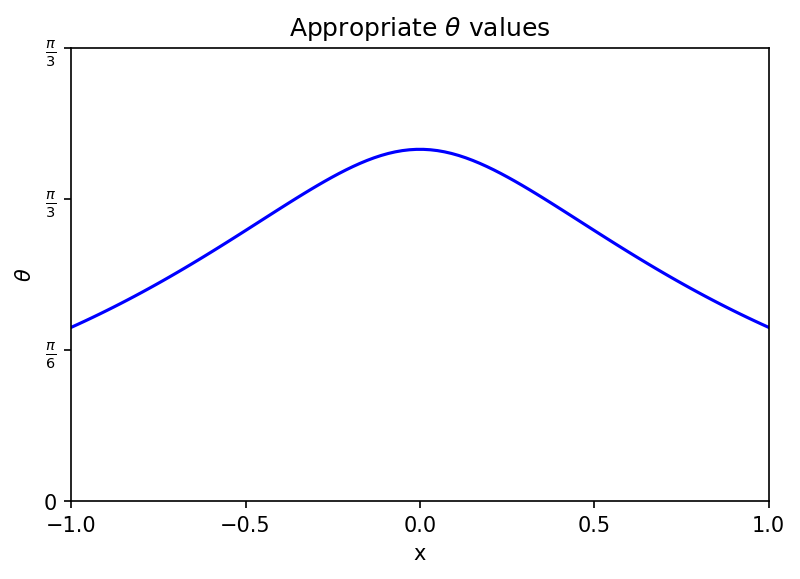

cost: 3.7249728933084256


In [5]:
def problem4(N=50):
    
    # get solution
    c = lambda x: -7*(x**2 - 1) / 10
    α = lambda x: (1 - c(x)**2)**(-1/2)
    a, b = -1, 1
    A, B = 0, 5
    x, y, guess, D = BVP_sol(N, c, α, A, B)
    
    # caluclate y prime
    yp = D@y

    # set up function to find the root of
    c1 = c(x)
    F = lambda θ : c1/np.cos(θ)+ np.tan(θ) - yp
    
    # get root
    guess = np.ones_like(x)
    θ = root(F, guess).x

    # use the interpolator on our root values
    grid = np.linspace(np.min(x), np.max(x), 100)
    θ = barycentric_interpolate(x, θ, grid)
    
    # plot
    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(111)
    ax.plot(grid, θ, 'b-')
    ax.set_ylabel(r'$\theta$')
    ax.set_xlabel('x')
    ax.set_title(r"Appropriate $\theta$ values")
    ax.set_xlim([-1, 1])
    ax.set_ylim([0, np.pi/2])
    ax.set_xticks([-1, -0.5, 0, 0.5, 1])
    ax.set_yticks([0, np.pi/6, np.pi/3, np.pi/2], labels=[r"0", 
                                                          r"$\frac{\pi}{6}$", 
                                                          r"$\frac{\pi}{3}$", 
                                                          r"$\frac{\pi}{3}$"])
    plt.show()
    
    # calculate path cost 
    # notice it is within the calculated range
    y = BarycentricInterpolator(x, y)
    Dy = BarycentricInterpolator(x, yp)
    cost = functional_eval(y, Dy, c, -1, 1)
    
    return cost
cost = problem4()
print('cost:', cost[0])